In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt

In [10]:
# TODO:
# - Actually b3 is not b3 but k2l :-)

# env = xt.load_madx_lattice('SPS_LS2_2025-10-14.seq')
# env.vars.load_madx('lhc_q20.str')

line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
env = line.env
env.vars.default_to_zero = False

env.vars.update(dict(
    b3a=-2.8e-03,# +/- 5.7e-04
    b3b=1.6e-03,# +/- 3.2e-04

    b5a=-7.9e+00,# +/- 5.4e-01
    b5b=-6.8e+00,# +/- 1.5e+00

    b7a=8.8e+04, # +/- 2.6e+04
    b7b=1.7e+05, # +/- 0.8e+05

    b3ar=0.0, #b3a*0.25,
    b3br=0.0, #b3b*0.25,

    b5ar=0.0, #b5a*0.25,
    b5br=0.0, #b5b*0.25,

    b7ar=0.0, #b7a*0.25,
    b7br=0.0, #b7b*0.25,
))

# line = env.sps
# line.particle_ref = xt.Particles(p0c=26e9, mass0=xt.PROTON_MASS_EV)

tw0 = line.twiss4d()

tt = line.get_table()
tt_bend = tt.rows[(tt.element_type=='Bend') | (tt.element_type=='RBend')]
tt_mba = tt_bend.rows['mba.*']
tt_mbb = tt_bend.rows['mbb.*']

# Generate random normal variables
np.random.seed(0)

env['on_error'] = 0

line.extend_knl_ksl(order=7, element_names=list(tt_mba.name) + list(tt_mbb.name))

for tt, family in zip([tt_mba, tt_mbb], ['a', 'b']):
    for order in [3, 5, 7]:
        rand_values = np.random.normal(0, 1, size=len(tt))
        for ii, nn in enumerate(tt_mba.name):
            new_expr = env.new_expr(
                f'(b{order}{family} + b{order}{family}r*{rand_values[ii]}) * on_error')
            env[nn].knl[order - 1] += new_expr

env['on_error'] = 0
tw_err_off = line.twiss4d()
env['on_error'] = 1
tw_err_on = line.twiss4d()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


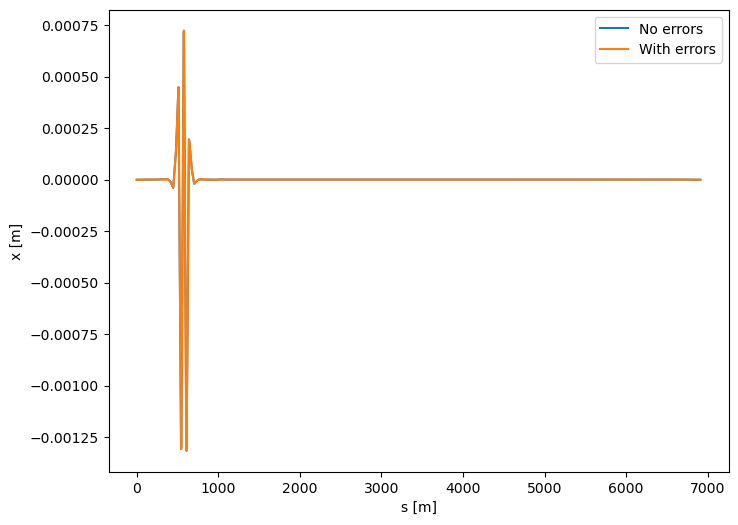

In [15]:
fig, ax = plt.subplots(1,1 , figsize=(8,6))
ax.plot(tw_err_off.s, tw_err_off.x, label='No errors')
ax.plot(tw_err_on.s, tw_err_on.x, label='With errors')
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.legend()

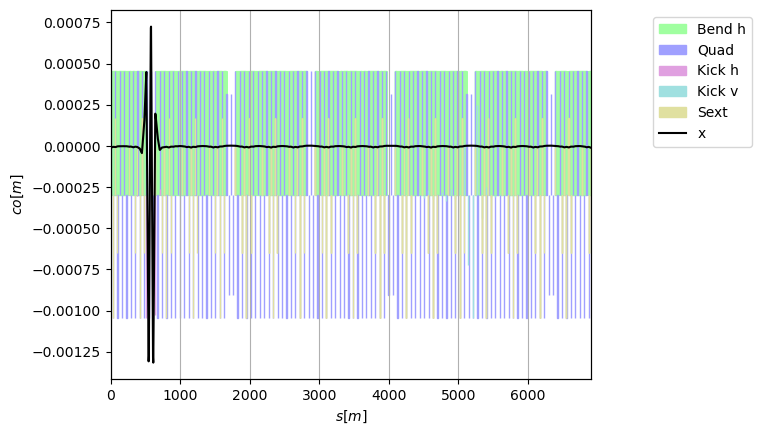

In [12]:
tw.plot('x')

In [13]:
line.to_json('sps_errors_with_aperture_inj_q20_beam_sagitta.json')